# U-Net Based Image Super-Resolution Training

This notebook implements a lightweight U-Net architecture for image super-resolution tasks. The model learns to transform low-resolution images into high-resolution outputs by training on paired HR-LR image datasets.

## Project Overview
- **Task**: Image Super-Resolution (SR)
- **Architecture**: Modified U-Net with reduced depth and channel numbers
- **Input**: Low-resolution images upsampled to 256×256 (bicubic interpolation)
- **Output**: High-resolution images at 256×256
- **Loss Function**: L1 Loss (Mean Absolute Error)

---

## 1. Import Dependencies

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm import tqdm

## 2. Device Configuration

Check if CUDA GPU is available for accelerated training. The model will automatically use GPU if available, otherwise fall back to CPU.

In [8]:
# 检查GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

使用设备: cuda
GPU: Quadro RTX 6000


## 3. Dataset Class

### SRDataset: Super-Resolution Dataset

This custom PyTorch Dataset class handles loading paired high-resolution (HR) and low-resolution (LR) images.

**Key Features:**
- Loads paired HR-LR images from separate directories
- Upsamples LR images to target size using bicubic interpolation
- Applies transformations (e.g., converting to tensors)
- Ensures HR and LR image counts match

**Process Flow:**
1. Load LR image (e.g., 64×64)
2. Load corresponding HR image (e.g., 256×256)
3. Upsample LR to HR size using bicubic interpolation
4. Convert both to tensors
5. Return (LR_upsampled, HR) pair

In [9]:
class SRDataset(Dataset):
    """超分辨率数据集"""
    def __init__(self, hr_dir, lr_dir, hr_size=256, transform=None):
        self.hr_dir = Path(hr_dir)
        self.lr_dir = Path(lr_dir)
        self.hr_size = hr_size
        self.transform = transform
        
        # 获取所有图片文件
        self.hr_images = sorted(list(self.hr_dir.glob('*.png')))
        self.lr_images = sorted(list(self.lr_dir.glob('*.png')))
        
        assert len(self.hr_images) == len(self.lr_images), "HR和LR图片数量不匹配"
        
    def __len__(self):
        return len(self.hr_images)
    
    def __getitem__(self, idx):
        # 读取图片
        hr_img = Image.open(self.hr_images[idx]).convert('RGB')
        lr_img = Image.open(self.lr_images[idx]).convert('RGB')
        
        # 将低分辨率图片上采样到目标尺寸（bicubic插值）
        lr_img = lr_img.resize((self.hr_size, self.hr_size), Image.BICUBIC)
        
        if self.transform:
            hr_img = self.transform(hr_img)
            lr_img = self.transform(lr_img)
        
        return lr_img, hr_img

## 4. U-Net Model Architecture

### Overview of U-Net for Super-Resolution

U-Net is a convolutional neural network originally designed for biomedical image segmentation, but it works excellently for image-to-image translation tasks like super-resolution. This implementation uses a **lightweight version** optimized for faster training.

---

### 4.1 DoubleConv Block

The basic building block of our U-Net. Each DoubleConv consists of:
- **Conv2d** (3×3 kernel, padding=1) → preserves spatial dimensions
- **ReLU** activation (inplace for memory efficiency)
- **Conv2d** (3×3 kernel, padding=1)
- **ReLU** activation

**Note**: BatchNorm layers are removed to accelerate training speed.

---

### 4.2 Down Block (Encoder)

Downsampling block that reduces spatial dimensions while increasing feature channels:
1. **MaxPool2d** (2×2) → reduces spatial size by half (e.g., 256×256 → 128×128)
2. **DoubleConv** → extracts features at this resolution

**Purpose**: Extract hierarchical features from coarse to fine.

---

### 4.3 Up Block (Decoder)

Upsampling block that increases spatial dimensions:
1. **Upsample** (nearest neighbor, 2×) → doubles spatial size (e.g., 64×64 → 128×128)
2. **Concatenate** with skip connection from encoder → combines low-level and high-level features
3. **DoubleConv** → refines the concatenated features

**Skip Connections**: The key innovation of U-Net! By concatenating encoder features with decoder features, the model can recover fine spatial details lost during downsampling.

---

### 4.4 Complete U-Net Architecture

#### Encoder Path (Downsampling):
```
Input: 3 channels (RGB), 256×256
    ↓ [DoubleConv]
  32 channels, 256×256
    ↓ [Down1: MaxPool + DoubleConv]
  64 channels, 128×128
    ↓ [Down2: MaxPool + DoubleConv]
 128 channels, 64×64
    ↓ [Down3: MaxPool + DoubleConv]
 256 channels, 32×32 (Bottleneck)
```

#### Decoder Path (Upsampling with Skip Connections):
```
256 channels, 32×32
    ↓ [Up1: Upsample + Concat(128 from Down2) + DoubleConv]
128 channels, 64×64
    ↓ [Up2: Upsample + Concat(64 from Down1) + DoubleConv]
 64 channels, 128×128
    ↓ [Up3: Upsample + Concat(32 from inc) + DoubleConv]
 32 channels, 256×256
    ↓ [Output Conv 1×1]
  3 channels, 256×256 (Output RGB image)
```

#### Channel Calculation in Decoder:
- **Up1**: Concatenates 256 (from Down3) + 128 (from Down2) = 384 input channels → outputs 128 channels
- **Up2**: Concatenates 128 (from Up1) + 64 (from Down1) = 192 input channels → outputs 64 channels
- **Up3**: Concatenates 64 (from Up2) + 32 (from inc) = 96 input channels → outputs 32 channels

---

### Model Optimizations for Speed:
1. **Reduced channel numbers**: Uses 32-64-128-256 instead of deeper networks
2. **Shallower depth**: Only 3 downsampling layers instead of 4-5
3. **No BatchNorm**: Removes BatchNorm layers to reduce computational overhead
4. **Nearest neighbor upsampling**: Faster than transposed convolutions

**Total Parameters**: ~1.9M (lightweight and fast to train)

In [10]:
class DoubleConv(nn.Module):
    """双卷积块 (Conv -> ReLU) * 2 - 移除BatchNorm加速训练"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """下采样块 MaxPool -> DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """上采样块 Upsample -> DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 使用最近邻上采样
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 拼接跳跃连接
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    """轻量级U-Net - 减少通道数和深度加速训练"""
    def __init__(self, n_channels=3, n_classes=3):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # 编码器 - 减少通道数
        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        
        # 解码器
        # up1: 拼接 down3输出(256) + down2输出(128) = 384
        self.up1 = Up(256 + 128, 128)
        # up2: 拼接 up1输出(128) + down1输出(64) = 192
        self.up2 = Up(128 + 64, 64)
        # up3: 拼接 up2输出(64) + inc输出(32) = 96
        self.up3 = Up(64 + 32, 32)
        
        # 输出层
        self.outc = nn.Conv2d(32, n_classes, kernel_size=1)
    
    def forward(self, x):
        # 编码路径
        x1 = self.inc(x)      # 32 channels
        x2 = self.down1(x1)   # 64 channels
        x3 = self.down2(x2)   # 128 channels
        x4 = self.down3(x3)   # 256 channels
        
        # 解码路径（带跳跃连接）
        x = self.up1(x4, x3)  # 256+128=384 -> 128
        x = self.up2(x, x2)   # 128+64=192 -> 64
        x = self.up3(x, x1)   # 64+32=96 -> 32
        
        # 输出
        return self.outc(x)

## 5. Training Configuration

### Hyperparameters

These parameters are tuned for **fast training** while maintaining good performance:

- **BATCH_SIZE = 8**: Smaller batches for faster iteration
- **LEARNING_RATE = 2e-4**: Higher learning rate to accelerate convergence
- **NUM_EPOCHS = 30**: Fewer epochs needed due to efficient architecture
- **TRAIN_SPLIT = 0.9**: 90% training data, 10% validation data

### Data Paths
- `HR_DIR`: Directory containing high-resolution ground truth images
- `LR_DIR`: Directory containing corresponding low-resolution input images
- `CHECKPOINT_DIR`: Where to save model checkpoints and training results

In [11]:
# 超参数 - 优化训练速度
BATCH_SIZE = 8  # 减小batch size加快单次迭代
LEARNING_RATE = 2e-4  # 提高学习率加快收敛
NUM_EPOCHS = 30  # 减少epoch数
TRAIN_SPLIT = 0.9  # 90%训练，10%验证

# 数据路径
HR_DIR = './dataset/high_resolution'
LR_DIR = './dataset/low_resolution'
CHECKPOINT_DIR = Path('./checkpoints')
CHECKPOINT_DIR.mkdir(exist_ok=True)

print(f"批次大小: {BATCH_SIZE}")
print(f"学习率: {LEARNING_RATE}")
print(f"训练轮数: {NUM_EPOCHS}")
print("优化策略: 轻量级模型 + 移除BatchNorm + 减少深度")

批次大小: 8
学习率: 0.0002
训练轮数: 30
优化策略: 轻量级模型 + 移除BatchNorm + 减少深度


## 6. Data Loading and Preprocessing

### Data Pipeline:
1. **Transform**: Convert PIL images to PyTorch tensors (values in [0, 1])
2. **Dataset**: Load full dataset with paired HR-LR images
3. **Split**: Randomly divide into training and validation sets
4. **DataLoader**: Create batch iterators for efficient GPU utilization

**Note**: `num_workers=0` is used to avoid multiprocessing issues during training.

In [12]:
# 数据转换
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 加载数据集（hr_size=256表示将LR上采样到256x256）
full_dataset = SRDataset(HR_DIR, LR_DIR, hr_size=256, transform=transform)

# 划分训练集和验证集
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# 数据加载器（num_workers=0避免multiprocessing问题）
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"总样本数: {len(full_dataset)}")
print(f"训练集: {train_size}")
print(f"验证集: {val_size}")
print(f"训练批次数: {len(train_loader)}")

总样本数: 1000
训练集: 900
验证集: 100
训练批次数: 113


## 7. Model Initialization

### Components:
- **Model**: U-Net with 3 input channels (RGB) and 3 output channels (RGB)
- **Loss Function**: L1 Loss (MAE) - better preserves sharp edges than L2 loss
- **Optimizer**: Adam optimizer with learning rate 2e-4
- **No LR Scheduler**: Using fixed learning rate for simplicity

The model parameters are displayed to verify the lightweight architecture (~1.9M parameters).

In [13]:
# 初始化模型
model = UNet(n_channels=3, n_classes=3).to(device)

# 损失函数和优化器
criterion = nn.L1Loss()  # L1损失（MAE）
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# 移除学习率调度器，使用固定学习率

# 打印模型信息
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n模型参数总数: {total_params:,}")
print(f"可训练参数: {trainable_params:,}")


模型参数总数: 1,946,947
可训练参数: 1,946,947


## 8. Training and Validation Functions

### train_epoch()
Trains the model for one complete epoch:
1. Set model to training mode
2. For each batch:
   - Forward pass: predict SR images
   - Calculate L1 loss between predictions and ground truth
   - Backward pass: compute gradients
   - Update model weights
3. Return average loss for the epoch

### validate()
Evaluates model on validation set:
1. Set model to evaluation mode (disables dropout, etc.)
2. Disable gradient computation (`torch.no_grad()`)
3. Calculate loss on validation batches
4. Return average validation loss

**Purpose**: Validation loss helps monitor overfitting and select the best model.

In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """训练一个epoch - 优化版本"""
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(train_loader, desc='训练')
    for lr_imgs, hr_imgs in pbar:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        
        # 前向传播
        optimizer.zero_grad()
        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return running_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """验证 - 优化版本"""
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in val_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            
            outputs = model(lr_imgs)
            loss = criterion(outputs, hr_imgs)
            
            running_loss += loss.item()
    
    return running_loss / len(val_loader)

## 9. Training Loop

This cell executes the main training loop for all epochs.

### Process for Each Epoch:
1. **Train**: Run one epoch on training set
2. **Validate**: Evaluate on validation set
3. **Record**: Save losses to history
4. **Checkpoint**:
   - Save best model when validation loss improves
   - Save checkpoint every 10 epochs for backup

### Monitoring:
- Training loss should decrease steadily
- Validation loss should track training loss (gap indicates overfitting)
- Progress bars show real-time batch-level loss

The best model is saved based on lowest validation loss, ensuring the model generalizes well to unseen data.

In [15]:
# 记录训练历史
history = {
    'train_loss': [],
    'val_loss': []
}

best_val_loss = float('inf')

print("\n开始训练...\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # 训练
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证
    val_loss = validate(model, val_loader, criterion, device)
    
    # 记录
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f"\n训练损失: {train_loss:.6f}")
    print(f"验证损失: {val_loss:.6f}")
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, CHECKPOINT_DIR / 'best_model.pth')
        print(f"✓ 保存最佳模型 (验证损失: {val_loss:.6f})")
    
    # 定期保存检查点
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, CHECKPOINT_DIR / f'checkpoint_epoch_{epoch+1}.pth')
        print(f"✓ 保存检查点: epoch_{epoch+1}")

print("\n训练完成！")
print(f"最佳验证损失: {best_val_loss:.6f}")


开始训练...


Epoch 1/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:13<00:00,  8.25it/s, loss=0.0184]



训练损失: 0.074577
验证损失: 0.028503
✓ 保存最佳模型 (验证损失: 0.028503)

Epoch 2/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:12<00:00,  9.39it/s, loss=0.0198]



训练损失: 0.022375
验证损失: 0.018497
✓ 保存最佳模型 (验证损失: 0.018497)

Epoch 3/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00, 10.16it/s, loss=0.0075]



训练损失: 0.013611
验证损失: 0.010287
✓ 保存最佳模型 (验证损失: 0.010287)

Epoch 4/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.40it/s, loss=0.0101]



训练损失: 0.009135
验证损失: 0.009581
✓ 保存最佳模型 (验证损失: 0.009581)

Epoch 5/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00, 10.14it/s, loss=0.0093]



训练损失: 0.008023
验证损失: 0.006815
✓ 保存最佳模型 (验证损失: 0.006815)

Epoch 6/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00,  9.94it/s, loss=0.0057]



训练损失: 0.006139
验证损失: 0.006482
✓ 保存最佳模型 (验证损失: 0.006482)

Epoch 7/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.37it/s, loss=0.0055]



训练损失: 0.005681
验证损失: 0.005098
✓ 保存最佳模型 (验证损失: 0.005098)

Epoch 8/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.28it/s, loss=0.0048]



训练损失: 0.005323
验证损失: 0.004533
✓ 保存最佳模型 (验证损失: 0.004533)

Epoch 9/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.43it/s, loss=0.0037]



训练损失: 0.005404
验证损失: 0.004118
✓ 保存最佳模型 (验证损失: 0.004118)

Epoch 10/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.40it/s, loss=0.0049]



训练损失: 0.004750
验证损失: 0.005532
✓ 保存检查点: epoch_10

Epoch 11/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.38it/s, loss=0.0039]



训练损失: 0.004434
验证损失: 0.004193

Epoch 12/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.56it/s, loss=0.0031]



训练损失: 0.004422
验证损失: 0.004398

Epoch 13/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00, 10.18it/s, loss=0.0041]



训练损失: 0.004171
验证损失: 0.004666

Epoch 14/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00,  9.93it/s, loss=0.0032]



训练损失: 0.004160
验证损失: 0.004426

Epoch 15/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.31it/s, loss=0.0032]



训练损失: 0.003985
验证损失: 0.003927
✓ 保存最佳模型 (验证损失: 0.003927)

Epoch 16/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.29it/s, loss=0.0063]



训练损失: 0.004265
验证损失: 0.004454

Epoch 17/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.50it/s, loss=0.0044]



训练损失: 0.003934
验证损失: 0.003909
✓ 保存最佳模型 (验证损失: 0.003909)

Epoch 18/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00, 10.03it/s, loss=0.0029]



训练损失: 0.003767
验证损失: 0.003489
✓ 保存最佳模型 (验证损失: 0.003489)

Epoch 19/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.58it/s, loss=0.0037]



训练损失: 0.003765
验证损失: 0.004486

Epoch 20/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.29it/s, loss=0.0050]



训练损失: 0.003783
验证损失: 0.003594
✓ 保存检查点: epoch_20

Epoch 21/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.34it/s, loss=0.0033]



训练损失: 0.003388
验证损失: 0.003841

Epoch 22/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00, 10.12it/s, loss=0.0037]



训练损失: 0.003600
验证损失: 0.004257

Epoch 23/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.30it/s, loss=0.0042]



训练损失: 0.003649
验证损失: 0.004481

Epoch 24/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.37it/s, loss=0.0041]



训练损失: 0.003727
验证损失: 0.003866

Epoch 25/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.36it/s, loss=0.0030]



训练损失: 0.003466
验证损失: 0.003039
✓ 保存最佳模型 (验证损失: 0.003039)

Epoch 26/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00, 10.22it/s, loss=0.0035]



训练损失: 0.003407
验证损失: 0.003403

Epoch 27/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:11<00:00,  9.78it/s, loss=0.0030]



训练损失: 0.003368
验证损失: 0.003013
✓ 保存最佳模型 (验证损失: 0.003013)

Epoch 28/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.39it/s, loss=0.0027]



训练损失: 0.003108
验证损失: 0.004374

Epoch 29/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.66it/s, loss=0.0040]



训练损失: 0.003379
验证损失: 0.002749
✓ 保存最佳模型 (验证损失: 0.002749)

Epoch 30/30
--------------------------------------------------


训练: 100%|██████████████████████| 113/113 [00:10<00:00, 10.31it/s, loss=0.0031]



训练损失: 0.003128
验证损失: 0.002793
✓ 保存检查点: epoch_30

训练完成！
最佳验证损失: 0.002749


## 10. Training Curve Visualization

Plots the training and validation loss curves over all epochs.

**What to Look For:**
- **Decreasing trend**: Both losses should decrease over time
- **Convergence**: Losses should stabilize toward the end
- **Overfitting**: If validation loss increases while training loss decreases, the model is overfitting
- **Underfitting**: If both losses remain high, the model needs more capacity or training

The curve is saved as an image for documentation and analysis.

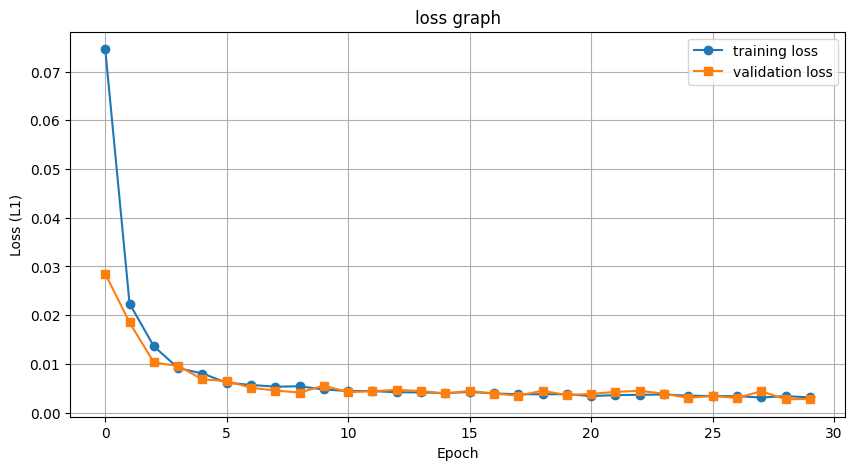

训练曲线已保存: checkpoints/training_curve.png


In [20]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='training loss', marker='o')
plt.plot(history['val_loss'], label='validation loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')
plt.title('loss graph')
plt.legend()
plt.grid(True)
plt.savefig(CHECKPOINT_DIR / 'training_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"训练曲线已保存: {CHECKPOINT_DIR / 'training_curve.png'}")

## 11. Load Best Model

Load the checkpoint with the lowest validation loss for inference and evaluation.

The model is set to evaluation mode to ensure consistent behavior (e.g., no dropout).

In [17]:
# 加载最佳模型
checkpoint = torch.load(CHECKPOINT_DIR / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"已加载最佳模型 (Epoch {checkpoint['epoch']+1}, 验证损失: {checkpoint['val_loss']:.6f})")

已加载最佳模型 (Epoch 29, 验证损失: 0.002749)


## 12. Visual Comparison of Results

Generates side-by-side comparisons of:
1. **Low Resolution Input**: The bicubic-upsampled LR image fed to the model
2. **Model Output**: The super-resolved image generated by our U-Net
3. **Ground Truth**: The actual high-resolution image

**Purpose**: Visually assess the model's performance in recovering fine details, textures, and overall image quality. Look for:
- Sharpness improvement over bicubic interpolation
- Texture restoration
- Absence of artifacts
- Color fidelity

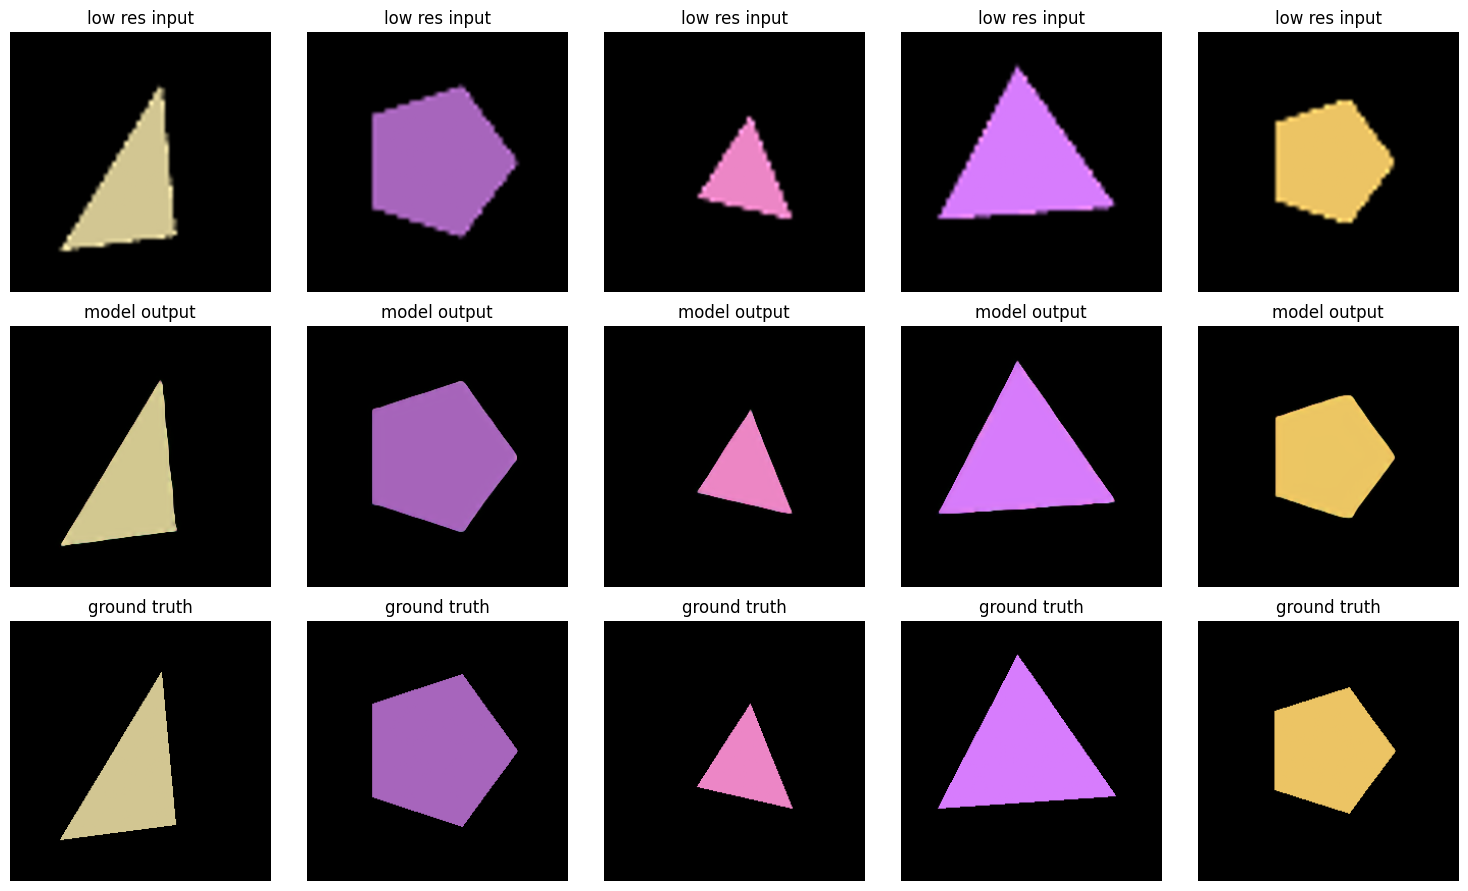

测试结果已保存: checkpoints/test_results.png


In [27]:
# 可视化测试结果
num_samples = 5
fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))

with torch.no_grad():
    for i in range(num_samples):
        # 获取一个样本
        lr_img, hr_img = val_dataset[i]
        lr_img_input = lr_img.unsqueeze(0).to(device)
        
        # 生成超分辨率图片
        sr_img = model(lr_img_input)
        
        # 转换为numpy显示
        lr_img_np = lr_img.cpu().numpy().transpose(1, 2, 0)
        hr_img_np = hr_img.cpu().numpy().transpose(1, 2, 0)
        sr_img_np = sr_img.squeeze(0).cpu().numpy().transpose(1, 2, 0)
        
        # 裁剪到[0, 1]
        lr_img_np = np.clip(lr_img_np, 0, 1)
        hr_img_np = np.clip(hr_img_np, 0, 1)
        sr_img_np = np.clip(sr_img_np, 0, 1)
        
        # 显示低分辨率
        axes[0, i].imshow(lr_img_np)
        axes[0, i].set_title('low res input')
        axes[0, i].axis('off')
        
        # 显示生成的高分辨率
        axes[1, i].imshow(sr_img_np)
        axes[1, i].set_title('model output')
        axes[1, i].axis('off')
        
        # 显示真实高分辨率
        axes[2, i].imshow(hr_img_np)
        axes[2, i].set_title('ground truth')
        axes[2, i].axis('off')

plt.tight_layout()
plt.savefig(CHECKPOINT_DIR / 'test_results.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"测试结果已保存: {CHECKPOINT_DIR / 'test_results.png'}")

## 13. Quantitative Evaluation Metrics

### PSNR (Peak Signal-to-Noise Ratio)
- Measures pixel-wise difference between images
- **Higher is better** (typically 25-35 dB for SR tasks)
- PSNR = 20 × log10(MAX / √MSE)
- Sensitive to pixel-level accuracy but may not correlate perfectly with perceptual quality

### SSIM (Structural Similarity Index)
- Measures structural similarity considering luminance, contrast, and structure
- **Range**: 0 to 1 (1 = identical images)
- Better correlates with human perception than PSNR
- Values above 0.95 indicate excellent quality

These metrics provide objective measurements to compare different models and training configurations.

In [25]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def calculate_metrics(model, val_loader, device):
    """计算PSNR和SSIM"""
    model.eval()
    psnr_scores = []
    ssim_scores = []
    
    with torch.no_grad():
        for lr_imgs, hr_imgs in tqdm(val_loader, desc='计算评估指标'):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            
            sr_imgs = model(lr_imgs)
            
            # 转换为numpy
            sr_imgs_np = sr_imgs.cpu().numpy().transpose(0, 2, 3, 1)
            hr_imgs_np = hr_imgs.cpu().numpy().transpose(0, 2, 3, 1)
            
            # 计算每张图片的指标
            for sr_img, hr_img in zip(sr_imgs_np, hr_imgs_np):
                sr_img = np.clip(sr_img, 0, 1)
                hr_img = np.clip(hr_img, 0, 1)
                
                psnr_score = psnr(hr_img, sr_img, data_range=1.0)
                ssim_score = ssim(hr_img, sr_img, data_range=1.0, channel_axis=2)
                
                psnr_scores.append(psnr_score)
                ssim_scores.append(ssim_score)
    
    return np.mean(psnr_scores), np.mean(ssim_scores)

# 计算指标
avg_psnr, avg_ssim = calculate_metrics(model, val_loader, device)

print("\n=== 评估指标 ===")
print(f"平均PSNR: {avg_psnr:.2f} dB")
print(f"平均SSIM: {avg_ssim:.4f}")

计算评估指标: 100%|█████████████████████████████| 13/13 [00:03<00:00,  4.00it/s]


=== 评估指标 ===
平均PSNR: 32.13 dB
平均SSIM: 0.9884


## 14. Training Summary

Generates a comprehensive summary of the training session including:
- Model architecture details
- Hyperparameters used
- Final performance metrics (loss, PSNR, SSIM)
- File paths to saved models and results

This summary is saved as a text file for future reference and experiment tracking.

In [26]:
# 保存训练总结
summary = f"""
训练总结
{'='*50}
模型: U-Net
训练轮数: {NUM_EPOCHS}
批次大小: {BATCH_SIZE}
学习率: {LEARNING_RATE}
损失函数: L1 Loss

最终结果:
- 最佳验证损失: {best_val_loss:.6f}
- 平均PSNR: {avg_psnr:.2f} dB
- 平均SSIM: {avg_ssim:.4f}

模型保存位置: {CHECKPOINT_DIR / 'best_model.pth'}
"""

print(summary)

with open(CHECKPOINT_DIR / 'training_summary.txt', 'w') as f:
    f.write(summary)

print(f"训练总结已保存: {CHECKPOINT_DIR / 'training_summary.txt'}")


训练总结
模型: U-Net
训练轮数: 30
批次大小: 8
学习率: 0.0002
损失函数: L1 Loss

最终结果:
- 最佳验证损失: 0.002749
- 平均PSNR: 32.13 dB
- 平均SSIM: 0.9884

模型保存位置: checkpoints/best_model.pth

训练总结已保存: checkpoints/training_summary.txt
